In [1]:
# from loadergp import NetCDFSR, standardize, colorize, plot_to_tensorboard
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader


import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim

import xarray as xr
import numpy as np
import torch
import glob

%load_ext autoreload
%autoreload 2
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

dataroot = "./data/era_interim/*.nc"

uncropped = xr.open_mfdataset(glob.glob(dataroot), combine='by_coords')
uncropped['10UV_GDS4_SFC'] = xr.ufuncs.hypot(uncropped['10U_GDS4_SFC'], uncropped['10V_GDS4_SFC'])
torch.cuda.empty_cache()
print(f"CUDA! {torch.cuda.memory_allocated()}")

CUDA! 0


In [2]:
midx = uncropped['10UV_GDS4_SFC'].values.shape[2] // 2
midy = uncropped['10UV_GDS4_SFC'].values.shape[1] //2
assert midx >= 2*midy

In [3]:
fine = uncropped['10UV_GDS4_SFC'][:, :, midx-midy:midx+midy]

In [4]:
sx, sy = 4, 4
coarse = fine.coarsen(g4_lon_2=sx).mean().coarsen(g4_lat_1=sy).mean()

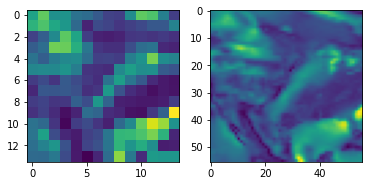

In [5]:
fig,ax = plt.subplots(1, 2)
ax[0].imshow(coarse[0, ...])
ax[1].imshow(fine[0, ...])

In [6]:
from loadergp import standardize
coarse = np.array(coarse)
fine = np.array(fine)

mean = np.nanmean(fine)
std = np.nanstd(fine)

print(f"Mean: {mean}")
print(f"Std: {std}")

fine = standardize(fine, mean, std)
coarse = standardize(coarse, mean, std)

# assert that the new means and std are 0 and 1
assert np.abs(fine.mean()) < 10E-5
assert np.abs(fine.std() - 1.0) < 10E-5

assert np.abs(coarse.mean()) < 10E-5
assert np.abs(coarse.std() - 1.0) < 10E-1

Mean: 3.9675991535186768
Std: 2.3133645057678223


In [7]:
# PCA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

fine_pca = fine.reshape(fine.shape[0], fine.shape[1]*fine.shape[2])
pca = PCA(n_components=800)
pca.fit(fine_pca)

PCA(n_components=800)

In [8]:
ncomp = pca.components_.shape[0]

In [9]:
fine_sp_basis = pca.components_.reshape(ncomp, fine.shape[1]*fine.shape[2])

In [10]:
# true_coefs = []
# from tqdm import tqdm
# with tqdm(total=fine.shape[0]) as pbar:
#     for y in np.rollaxis(fine, 0):
#         reg = LinearRegression().fit(fine_sp_basis.T, y.flatten())
#         true_coefs.append(reg.coef_)
#         pbar.update()

In [11]:
# true_coefs = np.array(true_coefs)

In [12]:
# true_coefs.shape

In [13]:
fine_t = torch.from_numpy(fine)
coarse_t = torch.from_numpy(coarse)
pcas_t = torch.from_numpy(fine_sp_basis)
# true_coefs_t = torch.from_numpy(true_coefs)
# pcas_t = torch.unsqueeze(pcas_t, 0).repeat(fine_t.size(0), 1, 1)
pcas_t.size()

torch.Size([800, 3136])

In [14]:
fine_t.size()

torch.Size([7308, 56, 56])

In [15]:
class NetCDFSR(Dataset):
    """Data loader for netCDF data for GAN Super Resolution"""

    def __init__(
        self,
        fine,
        coarse,
        pcas,
        device = device):
        """
        Args:
            mdsarr (xarray.MultiDataset): fine scale dataset
            mdscoarse (xarray.MultiDataset): fine coarse scale dataset
            transforms (torch.transform.Compose): default None, preprocessing image transforms
            norm (bool): whether to normalize/standardize data
            mean (float): which mean to standardize to
            std (float): which stdev to standardize to
        """
        self.fine = fine#.to(device)
        self.coarse = coarse#.to(device)
        self.pcas = pcas
        

    def __len__(self):
        return self.fine.shape[0]
    
    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        arr = self.fine[idx, ...]
        carr = self.coarse[idx, ...]
#         pcas_arr = self.pcas[idx, ...]

        arr = torch.unsqueeze(arr, 0)
        carr = torch.unsqueeze(carr, 0)
        pcas_arr = torch.unsqueeze(self.pcas, 0)
#         pcas_arr = self.pcas
#         true_coefs_arr = self.true_coefs
        
#         arr = torch.from_numpy(arr)#.long().float()
#         carr = torch.from_numpy(carr)#.long().float()

        return arr, carr, pcas_arr

In [16]:
dataset = NetCDFSR(
    fine_t,
    coarse_t,
    pcas_t,
    device=device
)

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=64,
    shuffle=True
)

In [17]:
# Decide which device we want to run on
real_batch, real_cbatch, pcas = next(iter(dataloader))
fixed = {"coarse": real_cbatch[:1, ...], "fine": real_batch[:1, ...]}
real_batch = torch.reshape(real_batch, (real_batch.size(0), real_batch.size(1), real_batch.size(2)*real_batch.size(3)))
# real_batch.size()

real_batch.size(), pcas.size(), pcas[:1, ...].size()

(torch.Size([64, 1, 3136]),
 torch.Size([64, 1, 800, 3136]),
 torch.Size([1, 1, 800, 3136]))

In [18]:
pcas[:1, ...].transpose(3, 2).size(), real_batch.size()

(torch.Size([1, 1, 3136, 800]), torch.Size([64, 1, 3136]))

In [19]:
A = torch.matmul(real_batch, pcas[:1, ...].transpose(3, 2)).transpose(0, 1)
B = torch.matmul(real_batch+torch.randn(real_batch.size()), pcas[:1, ...].transpose(3, 2)).transpose(0, 1)

coefficient_loss = nn.L1Loss()
coefficient_loss(A, B).item()

0.7959175109863281

In [20]:
from loadergp import Generator, Discriminator
discriminator = Discriminator(7, 14, 1).to(device)
generator = Generator(14, 56, 1).to(device)
lr = 0.00025

In [ ]:
G_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(.9, .99))
D_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(.9, .99))

# Set up trainer
from training import Trainer
trainer = Trainer(generator, discriminator, G_optimizer, D_optimizer,
                  use_cuda=torch.cuda.is_available(), print_every=50)

# Train model for 200 epochs
trainer.train(
    dataloader,
    epochs=600,
    fixed=fixed,
    save_training_gif=True
)



Epoch 1
CUDA! 646059520
Iteration 1
D: 7.610454559326172
GP: 7.614597320556641
Gradient norm: 0.12835974991321564
CUDA! 647030272
Iteration 51
D: 0.88767409324646
GP: 0.8896675109863281
Gradient norm: 0.7682574987411499
G: 1.4017246961593628
Content loss: 0.6211040019989014
EOF:  0.7924957871437073
CUDA! 647030784
Iteration 101
D: 1.0208046436309814
GP: 1.0332856178283691
Gradient norm: 0.8073247075080872
G: 1.185469388961792
Content loss: 0.45590081810951233
EOF:  0.7401012778282166

Epoch 2
CUDA! 647026688
Iteration 1
D: 1.1876614093780518
GP: 1.1918857097625732
Gradient norm: 0.7000452280044556
G: 1.2374364137649536
Content loss: 0.48990148305892944
EOF:  0.7584866285324097
CUDA! 647030784
Iteration 51
D: 0.8357411623001099
GP: 0.8374741673469543
Gradient norm: 0.8549079895019531
G: 1.0548831224441528
Content loss: 0.35729512572288513
EOF:  0.7075397968292236
CUDA! 647030784
Iteration 101
D: 0.5580685138702393
GP: 0.5536797642707825
Gradient norm: 0.9008927941322327
G: 0.9808846712

In [ ]:
np.random.randint(0, 10)